# This Notebook is for EDA and Clean-up of the provided data set for the Machine Learning course

## Set Up

In [2086]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SkLearn  Data Prep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# SkLearn Measurement Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# SkLearn Models
from sklearn.ensemble import RandomForestClassifier

# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [2087]:
# Get Main Data
path = os.getcwd()
path = path +'\\medical_data\\'
file = 'data.csv'

mainData = pd.read_csv(path+file)
mainData.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
0,24437208,135,Caucasian,Female,[50-60),NaN,2,1,1,8,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
1,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
2,189899286,729,Caucasian,Female,[80-90),NaN,1,3,7,4,...,No,No,No,No,No,No,No,No,Yes,NO
3,64331490,774,Caucasian,Female,[80-90),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,NO
4,14824206,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,NO


In [2088]:
# Get Admission Type Look-Up
file = 'id_lookup.csv'
admissionTypeLookUp = pd.read_csv(path+file)
admissionTypeLookUp = admissionTypeLookUp.iloc[:8]
admissionTypeLookUp['admission_type_id'] = admissionTypeLookUp['admission_type_id'].astype(int)
admissionTypeLookUp

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [2089]:
# Set Aside Copy of DF for Experiments
expData = mainData

## Re-Usable Functions

In [2090]:
def OrdinalEncoderFunc (df,listOfVars,order):
    df=df
    order=order
    enc = OrdinalEncoder(categories=[order])
    for col in listOfVars:
        col=col
        df[col] = enc.fit_transform(df[[col]])
    return df

In [2091]:
def nullAnalysis2(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per","Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [2092]:
# Custom Clean-Up Function For This Dataset -- 1
def EncodeResponse (df):
    df=df
    # Execute Encoding
    dummyTemp = pd.get_dummies(df['readmitted'],prefix='readmitted_')
    df = df.join(dummyTemp)
    # Customize/ Clean-Up
    ## Make 'readmitted' more logical so it is 0 when no and 1 when yes
    df = df.drop(columns=['readmitted']) # Drop Old Readmitted Column
    df = df.rename(columns={'readmitted__NO': 'readmitted'}) # Rename encoded column
    df = df.dropna(subset=['readmitted']) # drop puzzling 1 nan value
    df['readmitted'] = df['readmitted'].map({0:1, 1:0}) # reverse encoding to make logical
    return df

In [2093]:
# Custom Clean-Up Function For This Dataset -- 2
# TODO: Clean-up for demographic Vars (age, gender, race)

def AdditionalClean (df):
    df=df
    #1 - Null Clean-Up2 -- Fillna's for variables with nulls that have value to keep
    df['race'] = df['race'].fillna('Unknown')
    #2 - Encode Gender
    number = LabelEncoder()
    df['gender'] = number.fit_transform(df['gender']) # F -> 1, M -> 0, Unknown -> 2
    #3 - Covnert Age Buckets to Single Numeric
    df['age'] = df['age'].str[1:3]
    df['age'] = df['age'].str.rstrip('-')
    df['age'] = df['age'].astype('int')
    df = df.rename(columns={'age': 'age_10yrStart'})
    #3 - EncodeResponse
    df = EncodeResponse(df)
    return df

In [2094]:
#  Split function
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    df=df
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test


In [2095]:
def ROC_Curve_Plot(model,roc_x_test,roc_y_test):
    probas = model.predict_proba(roc_x_test) # get the probability distribution
    fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    roc_auc = auc(fpr, tpr) # get area under curve
    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC Curve for RF classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    return plt


In [2096]:
def createConfMatrix (regObj, y_test, y_pred, x_test):
    # Logistic Regression -- Step 5 -- Create Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm.columns.name = 'Predicted'
    cm.index.name = 'True'
    # Logistic Regression -- Step 6 -- Calc Accuracy From Test Set
    score = regObj.score(x_test, y_test)
    score = round(score,4)
    return cm, score

In [2097]:
def precisionRecall (y_test, y_pred):
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)
    f1 = round(f1_score(y_test, y_pred),4)
    return precision, recall, f1

In [2098]:
def FeatureImportance (regObj):
    # Best Tree-- Plot Most Important Features
    importances = rndClf.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=PredictorVar)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (8,4), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

## General EDA

In [2099]:
# Data Shape
mainData.shape

(71518, 50)

In [2100]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              71518 non-null  int64 
 1   patient_nbr               71518 non-null  int64 
 2   race                      69570 non-null  object
 3   gender                    71518 non-null  object
 4   age                       71518 non-null  object
 5   weight                    2853 non-null   object
 6   admission_type_id         71518 non-null  int64 
 7   discharge_disposition_id  71518 non-null  int64 
 8   admission_source_id       71518 non-null  int64 
 9   time_in_hospital          71518 non-null  int64 
 10  payer_code                40475 non-null  object
 11  medical_specialty         37041 non-null  object
 12  num_lab_procedures        71518 non-null  int64 
 13  num_procedures            71518 non-null  int64 
 14  num_medications       

In [2101]:
# Describe
mainData.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
count,7.151800e+04,7.151800e+04,69570,71518,71518,2853,71518.000000,71518.000000,71518.000000,71518.00000,...,71518,71518,71518,71518,71518,71518,71518,71518,71518,71518
unique,NaN,NaN,5,3,10,9,NaN,NaN,NaN,NaN,...,1,4,4,2,1,2,2,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),[75-100),NaN,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,53491,38025,18210,1195,NaN,NaN,NaN,NaN,...,71518,34921,71016,71511,71518,71516,71517,39494,54319,42985
mean,1.568156e+08,5.505160e+07,NaN,NaN,NaN,NaN,2.100254,3.593235,5.657457,4.28913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.003769e+08,3.947573e+07,NaN,NaN,NaN,NaN,1.508301,5.269771,4.162580,2.94921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.145807e+07,2.337577e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.440574e+08,4.816680e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,3.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.155513e+08,8.752222e+07,NaN,NaN,NaN,NaN,3.000000,3.000000,7.000000,6.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2102]:
numericFeatures = mainData.select_dtypes(include= np.number)
numericFeatures =  numericFeatures.drop(columns=['encounter_id','patient_nbr'])
numericFeatures.nunique()

admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
num_lab_procedures          116
num_procedures                7
num_medications              75
number_outpatient            33
number_emergency             18
number_inpatient             13
number_diagnoses             16
dtype: int64

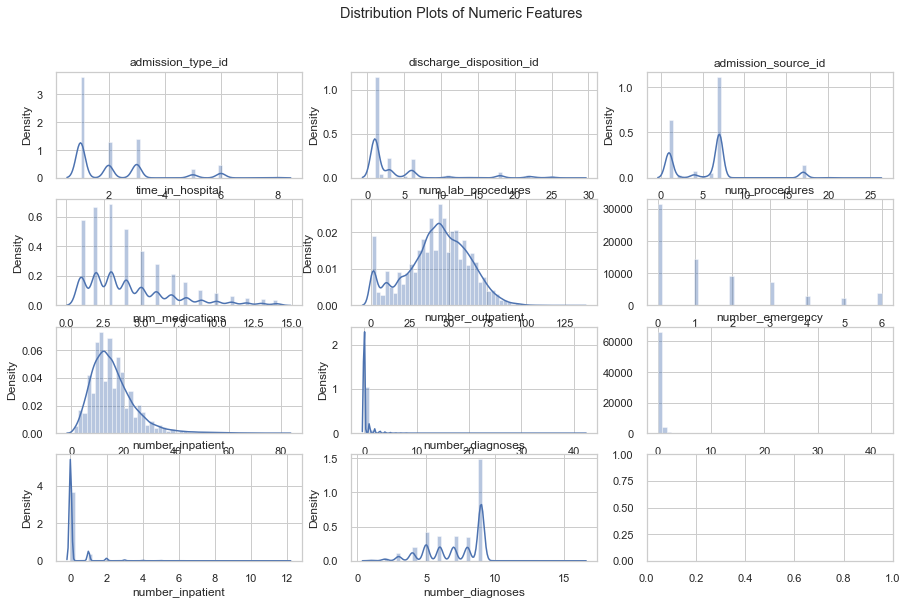

In [2103]:
# Distribution Plots

fig, axes = plt.subplots(4,3, sharex=False, sharey=False, figsize=(15,9))
fig.suptitle('Distribution Plots of Numeric Features')

sns.distplot(numericFeatures['admission_type_id'], ax=axes[0,0], kde=True).set(title='admission_type_id')
sns.distplot(numericFeatures['discharge_disposition_id'], ax=axes[0,1], kde=True).set(title='discharge_disposition_id')
sns.distplot(numericFeatures['admission_source_id'], ax=axes[0,2], kde=True).set(title='admission_source_id')
sns.distplot(numericFeatures['time_in_hospital'], ax=axes[1,0], kde=True).set(title='time_in_hospital')
sns.distplot(numericFeatures['num_lab_procedures'], ax=axes[1,1], kde=True).set(title='num_lab_procedures')
sns.distplot(numericFeatures['num_procedures'], ax=axes[1,2], kde=False).set(title='num_procedures')
sns.distplot(numericFeatures['num_medications'], ax=axes[2,0], kde=True).set(title='num_medications')
sns.distplot(numericFeatures['number_outpatient'], ax=axes[2,1], kde=True).set(title='number_outpatient')
sns.distplot(numericFeatures['number_emergency'], ax=axes[2,2], kde=False).set(title='number_emergency')
sns.distplot(numericFeatures['number_inpatient'], ax=axes[3,0], kde=True).set(title='number_inpatient')
sns.distplot(numericFeatures['number_diagnoses'], ax=axes[3,1], kde=True).set(title='number_diagnoses')

plt.show()

In [2104]:
# sns.pairplot(numericFeatures)

## General Data Clean-Up (Before Test/Train Split)

In [2105]:
# Print Null Summary
nullSummary = nullAnalysis2(mainData)
nullSummary

Count of Variables: 50
Count of Variables without nulls: 43
Count of Variables with null : 7


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
5,weight,71518,68665,96.011,9,object
11,medical_specialty,71518,34477,48.207,70,object
10,payer_code,71518,31043,43.406,17,object
2,race,71518,1948,2.724,5,object
20,diag_3,71518,1225,1.713,758,object
19,diag_2,71518,294,0.411,725,object
18,diag_1,71518,11,0.015,696,object


In [2106]:
# Null Clean-Up1 -- Drop Columns with high % of nulls, that aren't worth filling
mainData = mainData.drop(columns=['weight','medical_specialty','payer_code'])

In [2107]:
# Diag Clean-Up
## If diag_2 is null, then use diag_3.  If diag_1 is null, then use diag_2
## Solves all but 1 null Diag1, which is dropped
## TODO: Determine how to drop value from column that I pull from.
mainData['diag_2'] = mainData['diag_2'].fillna(mainData['diag_3'])
mainData['diag_1'] = mainData['diag_1'].fillna(mainData['diag_2'])
mainData = mainData.dropna(subset=['diag_1'])

In [2108]:
# Remove Deceased Patients
## Note: The research question is about predicting what patients will be re-admitted.
## In order to not skew the resutls, patients who died while admitted should be removed from the prediction

# Create List of Deceased
## Note: I only removed cases that explicity said the patient expired.
## I did not remove patients who were transfered to hospice (13,14)

expCodes = ['11','19','20','21']
mainData = mainData[~mainData['discharge_disposition_id'].isin(expCodes)]

In [2109]:
# Re-Run Null Summary
nullSummary = nullAnalysis2(mainData)
nullSummary

Count of Variables: 47
Count of Variables without nulls: 44
Count of Variables with null : 3


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
2,race,70433,1921,2.727,5,object
17,diag_3,70433,1224,1.738,757,object
16,diag_2,70433,243,0.345,724,object


In [2110]:
# Ordinal Encode Medication Variables

## Set List of Variabales
medCols = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone'] #Note: 'README' states 'sitagliptin' but not in data

## Define Func Params
df=mainData
listOfVars = medCols
order = ['No','Down','Steady','Up']

## Execute
mainData  = OrdinalEncoderFunc(df,listOfVars,order)

In [2111]:
# Add Variable For Number of Medications

mainData.insert(47,"num_of_meds", 0)
mainData['num_of_meds'] = mainData[medCols].ne(0).sum(axis=1)

In [2112]:
# Add Variable for Medication Level Up Or Down

## In the Medication columns 1 signifies that dosage decreased, 3 signifies that dosage increased
## This counts the number of 1 and coverts to a negative, then the adds the number of 3
## Result indicates the net level of medication change

mainData.insert(48,"med_level_direction", 0)
mainData['med_level_direction'] = ((mainData[medCols] == 1).sum(axis=1)*-1) + \
                                  (mainData[medCols] == 3).sum(axis=1)

### Replace Look-Up Values With Literal Values

In [2113]:
# Add Admission Type Values (Note: Did not drop ID)

# Add Column
mainData.insert(7,"admission_type_value", 0)

# Left Join
mainData = pd.merge(mainData,admissionTypeLookUp,on='admission_type_id')

# Replace Values
mainData['admission_type_value'] = mainData['description']
mainData = mainData.drop(columns=['description'])
mainData.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_type_value,admission_source_id,time_in_hospital,...,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,num_of_meds,med_level_direction
0,24437208,135,Caucasian,Female,[50-60),2,1,Urgent,1,8,...,0.0,0.0,0.0,0.0,0.0,Ch,Yes,<30,3,-1
1,60254142,1314,Caucasian,Female,[40-50),2,1,Urgent,1,2,...,0.0,0.0,0.0,0.0,0.0,No,Yes,>30,1,0
2,14897280,2025,Caucasian,Female,[70-80),2,3,Urgent,1,12,...,0.0,0.0,0.0,0.0,0.0,Ch,Yes,NO,2,-1
3,36469686,3069,Caucasian,Male,[60-70),2,1,Urgent,1,8,...,0.0,0.0,0.0,0.0,0.0,No,Yes,NO,1,0
4,20602470,8460,Caucasian,Male,[80-90),2,1,Urgent,1,2,...,0.0,0.0,0.0,0.0,0.0,No,Yes,NO,1,0


## Additional Data Clean-Up (After Test/Train Split)

In [2114]:
mainData = AdditionalClean(mainData) # Call Custom Clean-Up Function, Includes Encoding Response
mainData['race'].value_counts(dropna=False)

Caucasian          52663
AfricanAmerican    12692
Unknown             1921
Hispanic            1506
Other               1161
Asian                490
Name: race, dtype: int64

# Run Models

## Prep -- Split Data
TODO: This is the wrong place - should be earlier in the code - adding here for now to just get the models working
and because I was confused by where to split based on needing to clean the response variable (ie should I split twice)

TODO: Don't yet know how to deal with multiple response variables.  First pass will keep it simple and only predict
if readmitted is yes/no.  Will need to add timeline response variables later

In [2115]:
# TEMP: Create copy of mainData

tempModelingDF = mainData
tempModelingDF

,encounter_id,patient_nbr,race,gender,age_10yrStart,admission_type_id,discharge_disposition_id,admission_type_value,admission_source_id,time_in_hospital,...,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,num_of_meds,med_level_direction,readmitted__<30,readmitted__>30,readmitted
0,24437208,135,Caucasian,0,50,2,1,Urgent,1,8,...,0.0,0.0,0.0,Ch,Yes,3,-1,1,0,1
1,60254142,1314,Caucasian,0,40,2,1,Urgent,1,2,...,0.0,0.0,0.0,No,Yes,1,0,0,1,1
2,14897280,2025,Caucasian,0,70,2,3,Urgent,1,12,...,0.0,0.0,0.0,Ch,Yes,2,-1,0,0,0
3,36469686,3069,Caucasian,1,60,2,1,Urgent,1,8,...,0.0,0.0,0.0,No,Yes,1,0,0,0,0
4,20602470,8460,Caucasian,1,80,2,1,Urgent,1,2,...,0.0,0.0,0.0,No,Yes,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70428,402583472,141357506,AfricanAmerican,1,50,7,3,Trauma Center,7,6,...,0.0,0.0,0.0,No,Yes,1,0,0,0,0
70429,389059568,141433160,Caucasian,0,80,7,3,Trauma Center,7,4,...,0.0,0.0,0.0,No,No,0,0,0,0,0
70430,311376116,141459548,Caucasian,0,80,7,1,Trauma Center,7,2,...,0.0,0.0,0.0,Ch,Yes,2,0,0,0,0
70431,403231316,141466478,Caucasian,1,10,7,6,Trauma Center,7,9,...,0.0,0.0,0.0,No,No,0,0,0,0,0


In [2116]:
# Drop columns that are not needed
# TODO: Needs to move up
varsToDrop = ['admission_type_id','admission_source_id','admission_type_value','discharge_disposition_id',
              'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
              'number_outpatient','number_emergency','number_inpatient',
              'diag_1','diag_2', 'diag_3','number_diagnoses', 'max_glu_serum','A1Cresult',
              'change','diabetesMed']

tempModelingDF = tempModelingDF.drop(columns=varsToDrop)
tempModelingDF

# TODO - Parking Lot
#

,encounter_id,patient_nbr,race,gender,age_10yrStart,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,...,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,num_of_meds,med_level_direction,readmitted__<30,readmitted__>30,readmitted
0,24437208,135,Caucasian,0,50,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3,-1,1,0,1
1,60254142,1314,Caucasian,0,40,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1
2,14897280,2025,Caucasian,0,70,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2,-1,0,0,0
3,36469686,3069,Caucasian,1,60,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
4,20602470,8460,Caucasian,1,80,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70428,402583472,141357506,AfricanAmerican,1,50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
70429,389059568,141433160,Caucasian,0,80,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
70430,311376116,141459548,Caucasian,0,80,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,0,0,0,0
70431,403231316,141466478,Caucasian,1,10,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [2117]:
# TEMP
## Demographic Vars + Identifiers to Drop
tempModelingDF = tempModelingDF.drop(columns=['encounter_id','patient_nbr','race'])
## TODO - Parking Lot:
### 'gender', age_10yrStart

## Additional Response Vars to Drop
tempModelingDF = tempModelingDF.drop(columns=['readmitted__<30','readmitted__>30'])

In [2118]:
# Set or Reset Test/Train Split
# Params
df=tempModelingDF #TODO - Change From temp DF
ResponseVar = 'readmitted' #TODO - Change from single response variable
PredictorVar = df.columns.values.tolist()
PredictorVar.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar, ResponseVar)

In [2119]:
PredictorVar


['gender',
 'age_10yrStart',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide.metformin',
 'glipizide.metformin',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone',
 'num_of_meds',
 'med_level_direction']

## Random Forest

In [2120]:
# Random Forest
## Set and Fit Model
rndClf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=32,n_jobs=-1)
rndClf.fit(x_train,y_train)

## Make Predictions
y_pred = rndClf.predict(x_test)

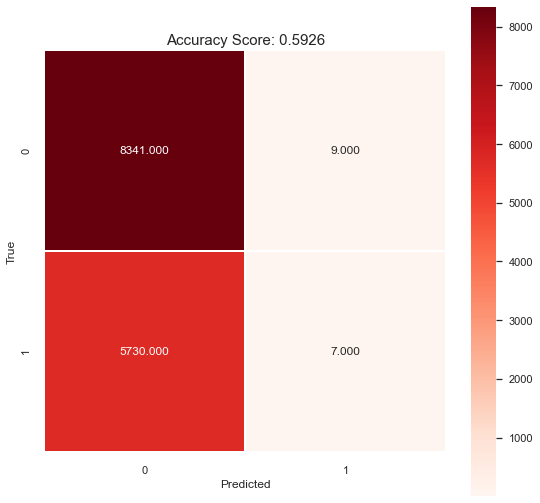

In [2121]:
# Random Forest -- Plot CM
regObj = rndClf # update mode
cm_y_test = y_test
cm_y_pred = y_pred # Update yPred
cm_x_test = x_test

cm, score = createConfMatrix(regObj,cm_y_test, cm_y_pred, cm_x_test)

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);

In [2122]:
# Random Forest -- Precision/Recall Scores

## Set Params
scores_y_test = y_test
scores_y_pred = y_pred # Update yPred

## Call Function
precision, recall, f1 = precisionRecall(scores_y_test, scores_y_pred)

## Print
print(f"Precision:",precision)
print(f"Recall:",recall)
print(f"F1:",f1)


Precision: 0.4375
Recall: 0.0012
F1: 0.0024


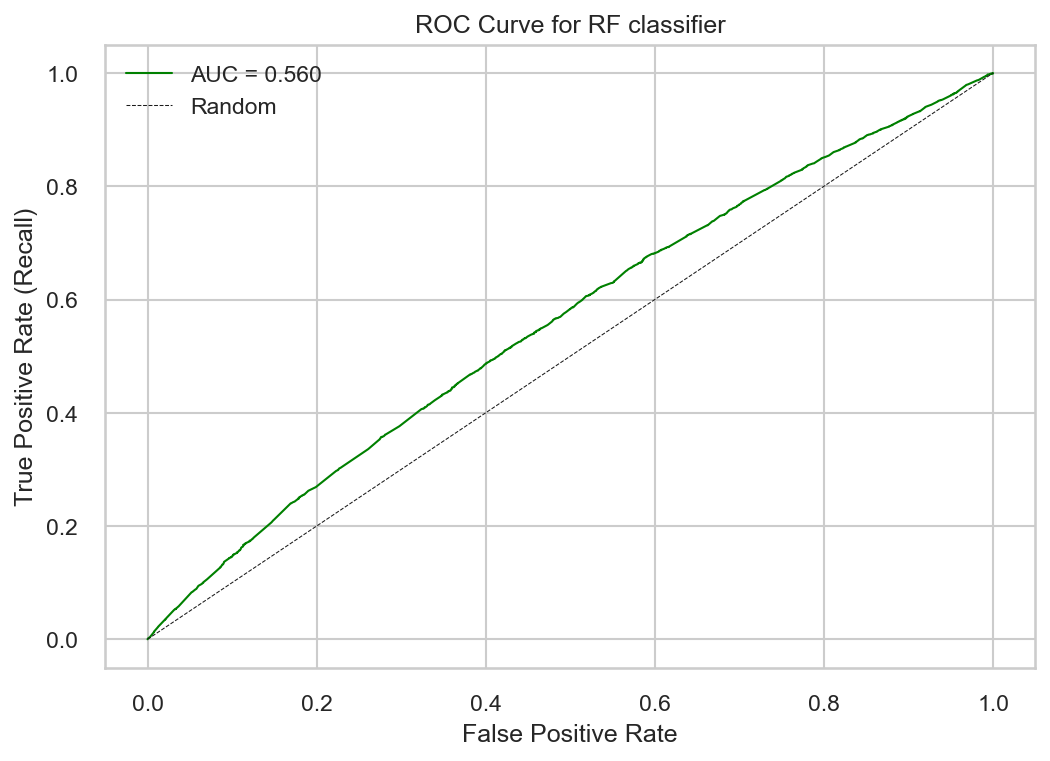

In [2123]:
# ROC Curve/ AUC Score
## Set Params
model = rndClf
roc_x_test = x_test
roc_y_test = y_test # Update yPred

## Call Function
ROC_Curve_Plot(model,roc_x_test, roc_y_test)
plt.show()

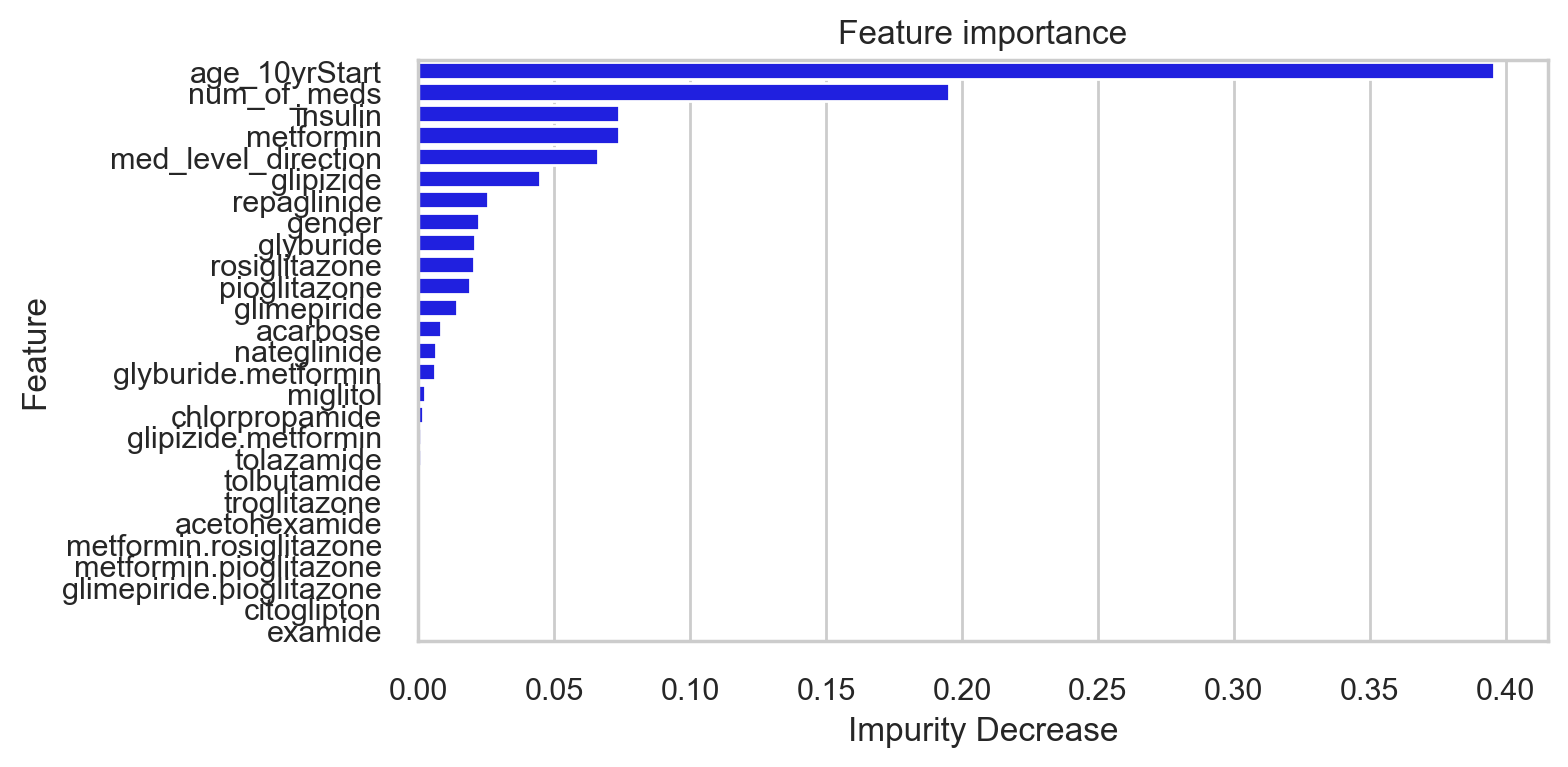

In [2124]:
# Random Forest -- Feature Importance

# Best Tree-- Plot Most Important Featuresk
feature_importances, fig = FeatureImportance(rndClf)
fig.tight_layout()

# Experimentation/ Scratchpad

In [2125]:
expData.sample(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
11002,74230650,10397106,Caucasian,Female,[50-60),NaN,1,1,7,4,...,No,No,No,No,No,No,No,No,Yes,NO
55330,141589290,89934453,Caucasian,Male,[60-70),NaN,3,1,1,7,...,No,No,No,No,No,No,No,No,No,NO
48733,119892624,79628085,Caucasian,Female,[60-70),NaN,3,6,4,7,...,No,No,No,No,No,No,No,Ch,Yes,NO
57529,218598006,92734209,Caucasian,Female,[80-90),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,Yes,>30
41066,192347616,60243183,AfricanAmerican,Male,[60-70),NaN,1,1,7,10,...,No,Steady,No,No,No,No,No,No,Yes,NO
46828,406665434,73838178,AfricanAmerican,Male,[60-70),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
6712,90326238,3972726,Caucasian,Male,[60-70),NaN,2,1,1,6,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
66590,214501524,109823274,Caucasian,Male,[50-60),NaN,2,1,7,4,...,No,Steady,No,No,No,No,No,No,Yes,NO
41684,135716712,61168221,AfricanAmerican,Male,[50-60),NaN,2,6,1,12,...,No,Steady,No,No,No,No,No,No,Yes,>30
16167,84511902,21296286,Caucasian,Female,[50-60),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,No,NO


In [2134]:
corr_matrix = mainData.corr()
corr_matrix['readmitted'].sort_values(ascending=False)

readmitted                  1.000000
readmitted__>30             0.823206
readmitted__<30             0.379575
number_inpatient            0.144738
number_diagnoses            0.107617
number_emergency            0.076701
age_10yrStart               0.071774
patient_nbr                 0.068992
number_outpatient           0.065085
time_in_hospital            0.061567
num_lab_procedures          0.053176
admission_source_id         0.047842
num_medications             0.038514
num_of_meds                 0.035503
insulin                     0.029125
glipizide                   0.026015
rosiglitazone               0.020427
repaglinide                 0.019891
admission_type_id           0.017794
pioglitazone                0.015513
acarbose                    0.011335
discharge_disposition_id    0.009189
miglitol                    0.008304
glyburide                   0.007631
acetohexamide               0.004566
nateglinide                 0.004331
troglitazone                0.003477
g

In [2127]:
mainData['gender'].value_counts(dropna=False)

0    37468
1    32962
2        3
Name: gender, dtype: int64

In [2128]:
expVars = ['num_of_meds','med_level_direction','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone','readmitted']

expSummaryVars = ['num_of_meds','med_level_direction','readmitted']

tempCor = mainData[expSummaryVars]
tempCor.sample(5)

,num_of_meds,med_level_direction,readmitted
50385,3,0,0
3468,1,0,0
41095,1,0,1
51531,2,0,0
63624,1,-1,0


<AxesSubplot:>

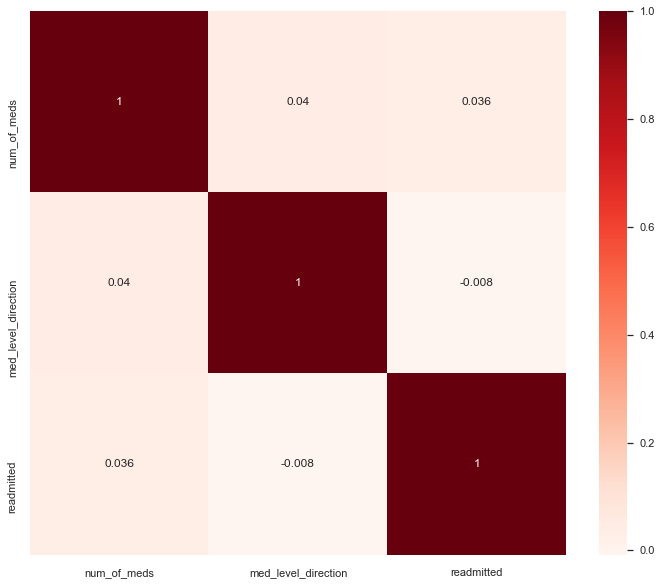

In [2129]:
#Multiple Regression -- Check Correlations in HeatMap
plt.figure(figsize=(12,10))
cor = round(tempCor.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [2130]:
#Multiple Regressions -- Correlation with output variable
responseVar = 'readmitted'
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
#relevant_features = cor_target[cor_target>=0.01] # Look for Features w/ greater 0.05 cor
#relevant_features
cor_target

num_of_meds            0.036
med_level_direction    0.008
readmitted             1.000
Name: readmitted, dtype: float64

In [2131]:
mainData.shape

(70433, 52)

In [2132]:
expData['temp-age'] = expData['age']
expData['temp-age'].value_counts(dropna=False)

[70-80)     18210
[60-70)     15960
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: temp-age, dtype: int64

In [2133]:
#Change Age Bucket to Starting Value

expData['age'].value_counts(dropna=False)


[70-80)     18210
[60-70)     15960
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: age, dtype: int64